Import the neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

Data Loading

In [2]:
try:
    # train.csv contains the target variable "y"
    df_train = pd.read_csv("train.csv")
    # test.csv is used for final predictios and does not contain "y"
    df_test = pd.read_csv("test.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The train and test files were not found")

Data loaded successfully!


In [3]:
# Display the first few rows of the training data
print("Training Data Head:")
df_train.head()

Training Data Head:


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Display the first few rows of the testing data
print("Testing Data Head:")
df_test.head()

Testing Data Head:


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
# Display the info of the training data
print("Training Data Info:")
print(df_train.info())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None


In [6]:
# Display the info of the testing data
print("Testing Data Info:")
print(df_test.info())

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB
None


In [7]:
# Separate the target variabl "y"
y = df_train["y"]
# Drop "ID" and "y" from the training features
X = df_train.drop(["ID","y"],axis=1)
# Drop "ID" from the test features
X_test_final = df_test.drop("ID",axis=1)

In [8]:
# Check for features that  are present only in the training or test set
# (Important for one-hot encoding conistency)
# We will combine X and X_test_final before encoding to ensure all categories are captured
X_combined = pd.concat([X,X_test_final],ignore_index=True)

Data Preprocessing and Feature Engineering

In [9]:
# Handle missing values for the training set
df_missing_train = df_train.isnull().sum()
print("Missing Values in the training sets")
print(df_missing_train)

Missing Values in the training sets
ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64


In [10]:
# Handle missing values for the testing set
df_missing_test = df_test.isnull().sum()
print("Missing Values in the testing sets")
print(df_missing_test)

Missing Values in the testing sets
ID      0
X0      0
X1      0
X2      0
X3      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 377, dtype: int64


In [11]:
# In this specific dataset, columns like X0, X1, etc., are categorical, and the rest are binary (0 or 1).
# We'll use the object type for categorical columns (X0, X1, X2, X3, X4, X5, X6, X8)
categorical_features = X.select_dtypes(include="object").columns.tolist()

# The rest of the features are binary and numerical
numerical_features = X.select_dtypes(exclude="object").columns.tolist()

In [12]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # Apply OneHotEncoder to the categorical features
        ("cat",OneHotEncoder(handle_unknown="ignore"),categorical_features),
        # Pass through the numerical (binary) features without any transformation
        ("num","passthrough",numerical_features)
    ],
    # Do not drop the remaining columns (which are already included in "num")
    remainder="drop"
)

In [13]:
# Apply the transformations on the combined dataset to get all possible categories
X_processed = preprocessor.fit_transform(X_combined)

In [14]:
# Separate the transformed data back into training and test sets
# The number of rows in the original training set (df_train.shape[0]) determines the split point
X_processed_train = X_processed[:len(X)]
X_processed_test = X_processed[len(X):]

Data Splitting

In [15]:
# Split the processed training data into trainign and validation sets for model evaluation
# 80% for training, 20% for validation/testing
X_train,X_val,y_train,y_val = train_test_split(
    X_processed_train,y,test_size=0.2,random_state=42
)
# random_state ensures reproducibility

In [16]:
print(f"Shape of original data (x): {X.shape}")
print(f"Shape of processed training data (X_processed_train): {X_processed_train.shape}")
print(f"Shape of processed validation data (X_val): {X_val.shape}")

Shape of original data (x): (4209, 376)
Shape of processed training data (X_processed_train): (4209, 579)
Shape of processed validation data (X_val): (842, 579)


Visualization: Target Variable Distribution

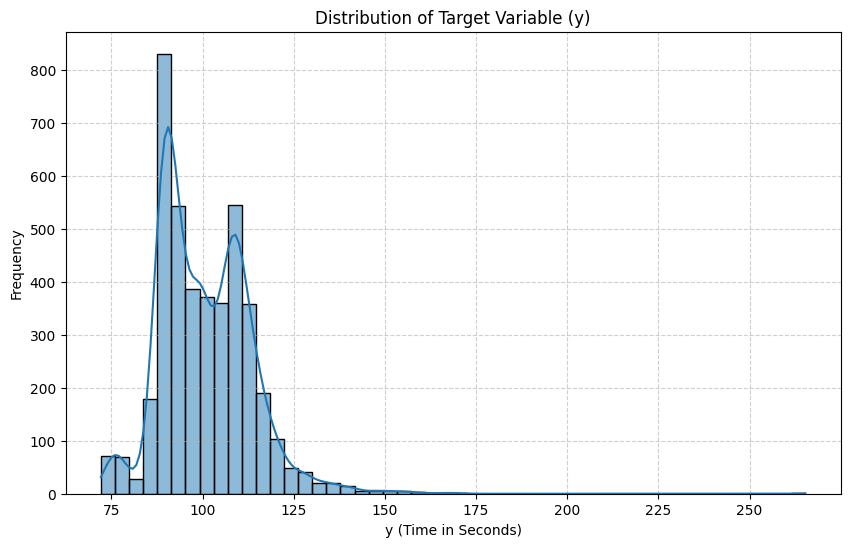

In [17]:
# Create a figure and axis for the plot
plt.figure(figsize=(10,6))
# Create a distribution plot (histogram with a kernel density estiamte) of the target
sns.histplot(y,kde=True,bins=50)
plt.title("Distribution of Target Variable (y)") # Set the plot title
plt.xlabel("y (Time in Seconds)") # Set the x-axis label
plt.ylabel("Frequency") # Set the y-axis label
plt.grid(True,linestyle="--",alpha=0.6) # Add a grid for better readabiliity
plt.show() # Display the plot

Model Training and Comparison

In [22]:
# Define a list of models to compare
models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso Regression', Lasso(random_state=42)), # Lasso requires a random state
    ('Ridge Regression', Ridge(random_state=42)), # Ridge requires a random state
    ('Elastic Net', ElasticNet(random_state=42)), # Elastic Net requires a random state
    ('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1)), # n_jobs=-1 uses all available cores
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)) 
    # 'reg:squarederror' is the objective for regression
]

results = [] # List to store the cross-validation results

print("\nStarting Cross-Validation (5-Fold RMSE) for Model Comparison...")

for name, model in models:
    # Use 5-fold cross-validation
    # scoring='neg_mean_squared_error' is used because cross_val_score minimizes the score.
    # We take the negative of MSE to make it a maximization problem, and then convert it back to RMSE.
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Convert the negative MSE results back to positive RMSE
    rmse_scores = np.sqrt(-cv_results)
    
    # Store the results: model name, mean RMSE, and standard deviation of RMSE
    results.append((name, rmse_scores.mean(), rmse_scores.std()))
    
    # Print the result for each model
    print(f"Model: {name:20s} | Mean RMSE: {rmse_scores.mean():.4f} | Std Dev: {rmse_scores.std():.4f}")

# Convert results to a DataFrame for easy comparison
df_results = pd.DataFrame(results, columns=['Model', 'Mean_RMSE', 'Std_Dev_RMSE']).sort_values(by='Mean_RMSE')

print("\nModel Comparison Results (Sorted by Mean RMSE):")
print(df_results)


Starting Cross-Validation (5-Fold RMSE) for Model Comparison...
Model: Linear Regression    | Mean RMSE: 8.9151 | Std Dev: 1.1232
Model: Lasso Regression     | Mean RMSE: 10.0036 | Std Dev: 0.9333
Model: Ridge Regression     | Mean RMSE: 8.7652 | Std Dev: 1.1363
Model: Elastic Net          | Mean RMSE: 10.2501 | Std Dev: 0.9031
Model: Random Forest        | Mean RMSE: 9.0147 | Std Dev: 1.2122
Model: XGBoost              | Mean RMSE: 9.2278 | Std Dev: 1.0642

Model Comparison Results (Sorted by Mean RMSE):
               Model  Mean_RMSE  Std_Dev_RMSE
2   Ridge Regression   8.765153      1.136306
0  Linear Regression   8.915098      1.123173
4      Random Forest   9.014712      1.212211
5            XGBoost   9.227776      1.064248
1   Lasso Regression  10.003607      0.933268
3        Elastic Net  10.250070      0.903147


Hyperparameter Tuning: XGBoost Regressor

In [23]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=42,n_jobs=1,eval_metric="rmse")

In [24]:
# Define the parameter grid to search
# We are tuning three key parameters:
# 1. n_estimators: The number of boosting rounds (trees)
# 2. learning_rate: Controls the step size shrinkage, preventing overfitting
# 3. max_depth: The maximum depth of a tree, controlling complexity
param_grid = {
    'n_estimators': [100, 200], # Testing 100 and 200 trees (often more is better, but takes longer)
    'learning_rate': [0.05, 0.1], # Testing two common learning rates
    'max_depth': [3, 5] # Testing shallow (3) and medium (5) trees
}

In [25]:
# Setup the GridSearch Cross-Validation
# scoring="neg_mean_squared_error" for RMSE optimization
grid_search = GridSearchCV(
    estimator=xgb_model, # The model to tune
    param_grid=param_grid, # The hyperparameter to test
    scoring="neg_mean_squared_error", # The metric to optimize (will be converted to RMSE)
    cv=3, # Use 3-fold cross-validation for speed (often 5 is used)
    verbose=1, # Print progress
    n_jobs=1 # Use all available cores
)

In [26]:
print("Starting Hyperparameter Tuning for XGBoost Regressor.....")
# Fit the grid search to the training data
grid_search.fit(X_train,y_train)

Starting Hyperparameter Tuning for XGBoost Regressor.....
Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'n_estimators': [100, 200]}"
,scoring,'neg_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [27]:
# Get the best parameters and the best score (RMSE)
best_params = grid_search.best_params_
best_score_rmse = np.sqrt(-grid_search.best_score_)

In [28]:
print("Grid Search Complete")
print(f"Best Hyperparameters found: {best_params}")
print(f"Best Cross-Valiadtion RMSE: {best_score_rmse:.4f}")

Grid Search Complete
Best Hyperparameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Cross-Valiadtion RMSE: 8.5435


In [29]:
# Assign the best estimator to the final model
final_model = grid_search.best_estimator_

Model Evaluation

In [30]:
# Make predictions on the valdation set
y_pred_val = final_model.predict(X_val)

In [31]:
# Calculate RMSE (Root Mean Squared Error)
final_rmse = np.sqrt(mean_squared_error(y_val,y_pred_val))

In [32]:
# Calculate R-squared (Coefficient of Determination)
final_r2 = r2_score(y_val,y_pred_val)

In [33]:
print(f"----- Final Model Evaluation (XGBoost) ------")
print(f"Validation RMSE: {final_rmse:.4f} (Lower is better)")
print(f"Validation R-squared (R2): {final_r2:.4f} (Closer to 1 is better)")

----- Final Model Evaluation (XGBoost) ------
Validation RMSE: 7.8850 (Lower is better)
Validation R-squared (R2): 0.6006 (Closer to 1 is better)


Visualization After Training

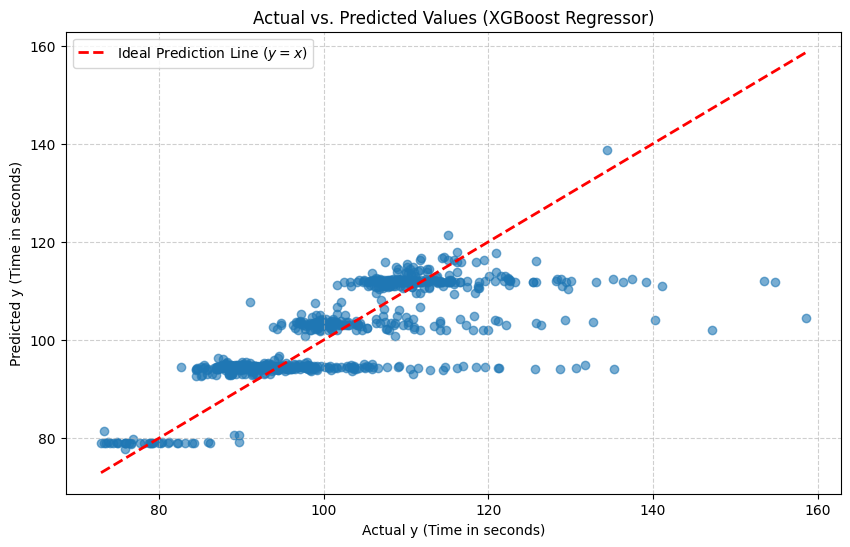

In [34]:
# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))
# Create a scatter plot of Actual vs. Predicted values
plt.scatter(y_val, y_pred_val, alpha=0.6)

# Plot the ideal line (y=x), where actual equals predicted
max_val = max(y_val.max(), y_pred_val.max())
min_val = min(y_val.min(), y_pred_val.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, 
         label='Ideal Prediction Line ($y=x$)')

plt.title('Actual vs. Predicted Values (XGBoost Regressor)') # Set the plot title
plt.xlabel('Actual y (Time in seconds)') # Set the x-axis label
plt.ylabel('Predicted y (Time in seconds)') # Set the y-axis label
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid
plt.legend() # Show the legend
plt.show() # Display the plot

New Prediction Input 

In [35]:
# Make predictions on the final test set
# X_processed_test was created in Step 2 from the loaded test.csv data
y_pred_test = final_model.predict(X_processed_test)

# Create a submission DataFrame (assuming the ID from the original test file)
df_submission = pd.DataFrame({'ID': df_test['ID'], 'y': y_pred_test})

print("\n--- Sample of Final Test Predictions ---")
print(df_submission.head())

# Save the predictions to a CSV file (typical Kaggle submission format)
df_submission.to_csv('submission_predictions.csv', index=False)
print("\nPredictions saved to 'submission_predictions.csv'")

# Simple example for a single new data point prediction:
# Since the input must be one-hot encoded and match the 
# features of the training data, a new prediction requires
# passing the new data point through the same ColumnTransformer
# used earlier.

# Create a simplified function for a new prediction:
def predict_new_input(new_data, preprocessor, model, feature_columns):
    # Convert the input dictionary to a DataFrame
    new_df = pd.DataFrame([new_data], columns=feature_columns)
    
    # Transform the new data using the fitted preprocessor
    # We must use the .transform() method, NOT .fit_transform()
    new_data_processed = preprocessor.transform(new_df)
    
    # Make the prediction
    prediction = model.predict(new_data_processed)
    return prediction[0]

# --- Example of creating a new input (using the first test row as a template) ---
# Create an input dictionary based on a row from the original X_test_final
example_input_data = X_test_final.iloc[0].to_dict()

# Predict the 'y' value for the example input
predicted_y = predict_new_input(
    example_input_data, 
    preprocessor, 
    final_model, 
    X.columns # Use the original feature columns for safety
)

print(f"\n--- New Input Prediction ---")
print(f"Example Input: {example_input_data['X0']} (for X0) and {example_input_data['X10']} (for X10)")
print(f"Predicted 'y' for this new input: {predicted_y:.4f} seconds")


--- Sample of Final Test Predictions ---
   ID           y
0   1   78.931725
1   2   94.618233
2   3   78.931725
3   4   78.931725
4   5  111.898117

Predictions saved to 'submission_predictions.csv'

--- New Input Prediction ---
Example Input: az (for X0) and 0 (for X10)
Predicted 'y' for this new input: 78.9317 seconds
